In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import sys 
import os
import os.path as op
import matplotlib.pyplot as plt

dataset_id = "ds000171"
bids_root = "./ds000171"  
deriv_root = os.path.join(bids_root, 'derivatives')
preproc_root = os.path.join(deriv_root, 'preprocessed_data')
subject_01 = "sub-control01"


In [2]:
image = op.join(preproc_root, subject_01, 'func','concat_run_std_moco_10mm_smooth.nii.gz')
img = nib.load(image)
affine = img.affine
data = np.asanyarray(img.dataobj)
data.shape
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
print(vol_shape, n_vols)
data.shape

(80, 80, 50) 525


(80, 80, 50, 525)

In [3]:
# YOUR CODE HERE
# Note: In our case the background is encoded as 0 
# you can consider that the first volume's background 
# voxels are the same as all following volumes

slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 
# (NOTE: that the order is important)
samples = data[slice_non_background]

In [4]:
# YOUR CODE HERE
# Calculate the mean across columns
spatial_means = np.mean(samples, axis=1)
# Row means copied n_vols times so that we substract for each timepoint the spatial mean
row_means = np.outer(spatial_means, np.ones(n_vols))
# Subtract the means for each row, put the result into X
X = samples - row_means
# Verify that the spatial mean behaves as expected after substraction
assert np.abs(X.mean(axis=-1)).max() < 1e-10

In [5]:
X.shape

(320000, 525)

In [6]:
from sklearn.decomposition import PCA
nb_components = 10

# YOUR CODE HERE 

pca = PCA(n_components=nb_components)
pca.fit(X.T) # NOTE: Takes matrix of shape (nb_samples, nb_features)

PCA(n_components=10)

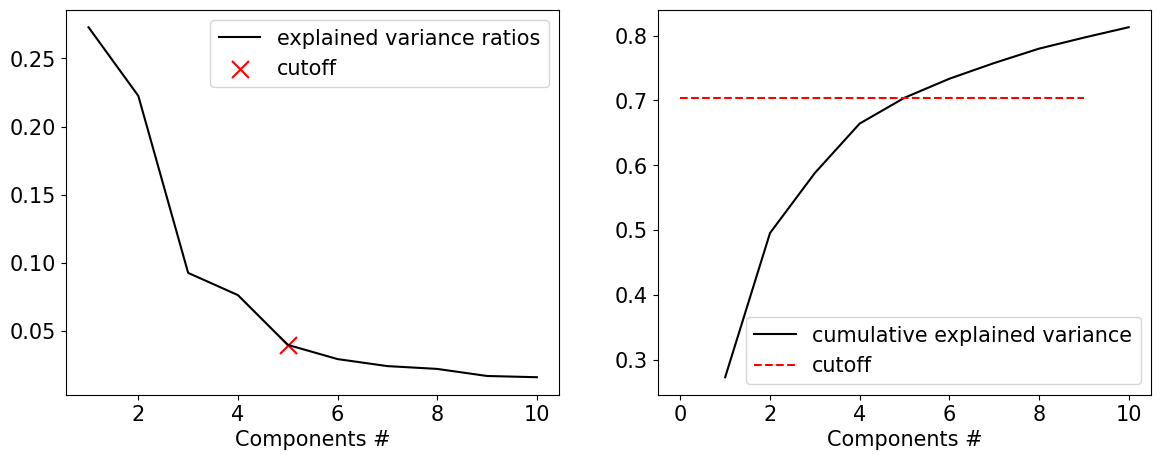

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)
nb_clusters = 5


ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

In [8]:
# YOUR CODE HERE 
pca_clusters = [] # List of spatial components (you should have in the list elements of the shape 30)
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx]
    pca_clusters.append(pca_component)

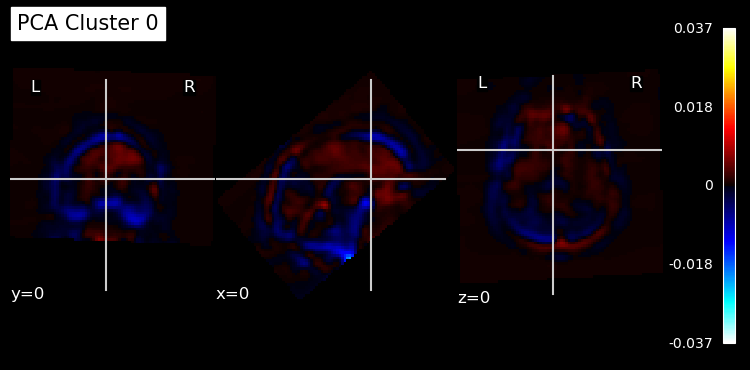

In [12]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(img)
visual_idx = 0
plot_stat_map(nib.Nifti1Image(pca_clusters[visual_idx], affine), bg_img=mean_img_, threshold=0,
               cut_coords=[0,0,0], black_bg=True,
              title=f'PCA Cluster {visual_idx}')

plt.show()

### 